# Residual Bootstrapping

In [89]:
# Normal Libraries
# =======================================================
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import polars as pl 

pd.options.display.float_format = "{:,.2f}".format

# ML Libraries
# =======================================================
from scipy.stats import norm
from sklearn.ensemble import GradientBoostingRegressor


from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals

## Data

In [90]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df["year"] = df["date"].dt.year
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df["Passengers"] = df["Passengers"].astype(float)

    return df 

df = read_dataset()
df

,Passengers,date,year
0,112.00,1949-01-01,1949
1,118.00,1949-02-01,1949
2,132.00,1949-03-01,1949
3,129.00,1949-04-01,1949
4,121.00,1949-05-01,1949
...,...,...,...
139,606.00,1960-08-01,1960
140,508.00,1960-09-01,1960
141,461.00,1960-10-01,1960
142,390.00,1960-11-01,1960


In [91]:
ts_variable = "Passengers"
date_variable = "date"

In [92]:
# Lest Create the Train and Test Data 
train_size = int(len(df[date_variable])*0.8)
train = df[:train_size].copy()
test = df[train_size:].copy()
train

,Passengers,date,year
0,112.00,1949-01-01,1949
1,118.00,1949-02-01,1949
2,132.00,1949-03-01,1949
3,129.00,1949-04-01,1949
4,121.00,1949-05-01,1949
...,...,...,...
110,362.00,1958-03-01,1958
111,348.00,1958-04-01,1958
112,363.00,1958-05-01,1958
113,435.00,1958-06-01,1958


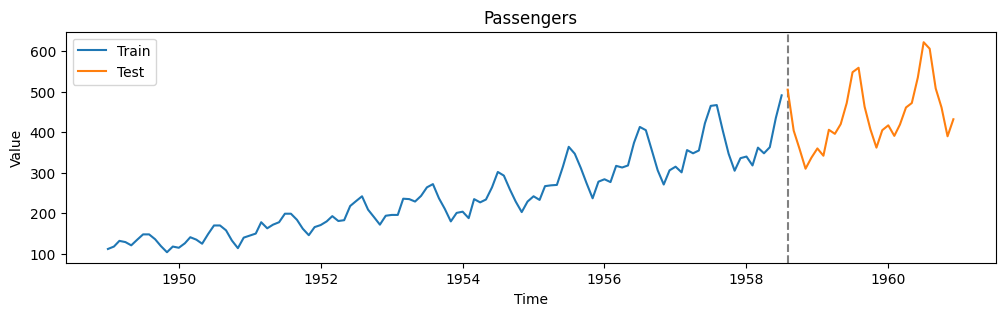

In [93]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.axvline(x = test[date_variable].values[0], color = "gray", linestyle = "--")
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

## Residual Bootstrapping

In [94]:
class ResidualSimulationModel:

    def __init__(self, df, date_variable, ts_variable, n_past_steps):

        self.date = df[date_variable]
        self.ts = df[ts_variable]
        self.model = GradientBoostingRegressor(n_estimators = 30, random_state = 666)
        self.n_past_steps = n_past_steps + 1

    def create_training_dataset(self):

        train_data = pd.DataFrame()

        for i in range(len(train) + 1 - self.n_past_steps):
            
            cut = train.iloc[i:i+self.n_past_steps, :].copy()
            row = pd.Series(cut[ts_variable].values)
            train_data = pd.concat([train_data, row], axis = 1)

        train_data = train_data.T
        train_data.columns = [f'lag_{i}' for i in reversed(range(1, self.n_past_steps))] + ["target"]
        
        self.train_data = train_data 
        self.X_train = self.train_data.drop(columns = "target")
        self.y_train = self.train_data["target"]

    def train_model(self):

        self.model.fit(self.X_train, self.y_train)

        self.y_train_pred = self.model.predict(self.X_train) 

        self.residuals = self.y_train - self.y_train_pred 
    
    def sample_from_residuals(self):

        return self.residuals.sample(1).values[0]

    def forecast_n_steps(self, n_steps):

        predict_data = pd.DataFrame()

        # First Iteration
        forecast_data = pd.DataFrame(self.train_data.iloc[-1, 1:]).T
        forecast_data.columns = [f'lag_{i}' for i in reversed(range(1, self.n_past_steps))]
        forecast_data = forecast_data.astype(float)
        y_forecast = self.model.predict(forecast_data)
        forecast_data["target"] = y_forecast

        predict_data = pd.concat([predict_data, forecast_data], axis = 0)

        # Next Iterations
        for _ in range(1, n_steps):

            forecast_data = pd.DataFrame(predict_data.iloc[-1, 1:]).T
            forecast_data.columns = [f'lag_{i}' for i in reversed(range(1, self.n_past_steps))]
            forecast_data = forecast_data.astype(float)
            y_forecast = self.model.predict(forecast_data)
            forecast_data["target"] = y_forecast

            predict_data = pd.concat([predict_data, forecast_data], axis = 0)

        return predict_data
    
    def residuals_bootstrapping_forecast(self, n_steps):

        predict_data = pd.DataFrame()

        # First Iteration
        forecast_data = pd.DataFrame(self.train_data.iloc[-1, 1:]).T
        forecast_data.columns = [f'lag_{i}' for i in reversed(range(1, self.n_past_steps))]
        forecast_data = forecast_data.astype(float)
        y_forecast = self.model.predict(forecast_data)
        forecast_data["target"] = y_forecast + self.sample_from_residuals() # Add an error 

        predict_data = pd.concat([predict_data, forecast_data], axis = 0)

        # Next Iterations
        for _ in range(1, n_steps):

            forecast_data = pd.DataFrame(predict_data.iloc[-1, 1:]).T
            forecast_data.columns = [f'lag_{i}' for i in reversed(range(1, self.n_past_steps))]
            forecast_data = forecast_data.astype(float)
            y_forecast = self.model.predict(forecast_data)
            forecast_data["target"] = y_forecast + self.sample_from_residuals() # Add an error

            predict_data = pd.concat([predict_data, forecast_data], axis = 0)

        return predict_data


model = ResidualSimulationModel(train, date_variable, ts_variable, n_past_steps = 14)
model.create_training_dataset() 
model.X_train

,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1
0,112.00,118.00,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00
0,118.00,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00
0,132.00,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00,135.00
0,129.00,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00,135.00,125.00
0,121.00,135.00,148.00,148.00,136.00,119.00,104.00,118.00,115.00,126.00,141.00,135.00,125.00,149.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,315.00,301.00,356.00,348.00,355.00,422.00,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00
0,301.00,356.00,348.00,355.00,422.00,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00
0,356.00,348.00,355.00,422.00,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00,348.00
0,348.00,355.00,422.00,465.00,467.00,404.00,347.00,305.00,336.00,340.00,318.00,362.00,348.00,363.00


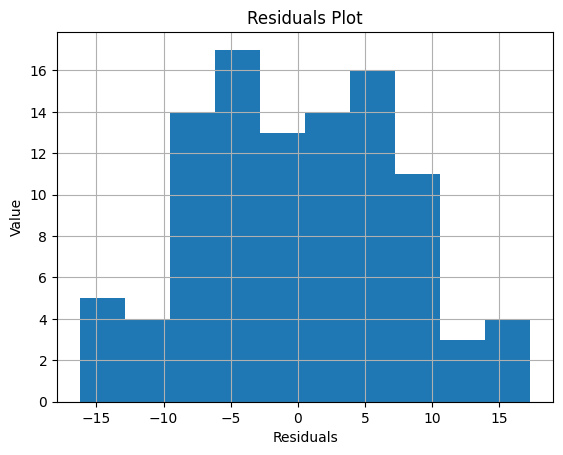

In [95]:
model.train_model()

residuals = model.residuals
residuals.hist()
plt.xlabel("Residuals")
plt.ylabel("Value")
plt.title("Residuals Plot")
plt.show()

In [96]:
# Normal Forecasting
forecast = model.forecast_n_steps(n_steps=len(test))

# Simulations
simulation_list = []
n_simulations = 10

for _ in range(n_simulations):
    forecast_boostrapping = model.residuals_bootstrapping_forecast(n_steps = len(test))
    simulation_list.append(forecast_boostrapping)


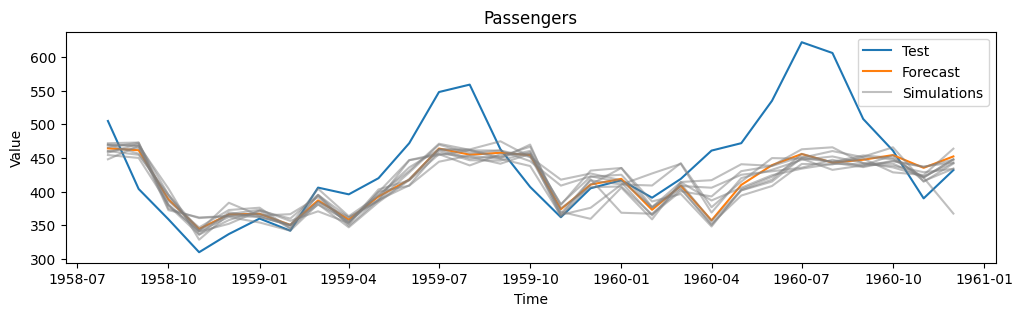

In [97]:
# Plot
plt.figure(figsize=(12,3))
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.plot(test[date_variable], forecast["target"], label = "Forecast")
plt.plot(test[date_variable], simulation_list[0]["target"], color = "gray", alpha = 0.5, label = "Simulations")
for i in range(1, n_simulations):
    plt.plot(test[date_variable], simulation_list[i]["target"], color = "gray", alpha = 0.5)
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

In [98]:
results = pd.DataFrame()
for i in range(n_simulations):

    results = pd.concat([results, simulation_list[i]["target"].T], axis = 1)
    
results["mean"] = results.mean(axis = 1)
results["std"] = results.std(axis = 1)
results["lower_bound"] = results["mean"] + 1.96*results["std"]
results["upper_bound"] = results["mean"] - 1.96*results["std"]


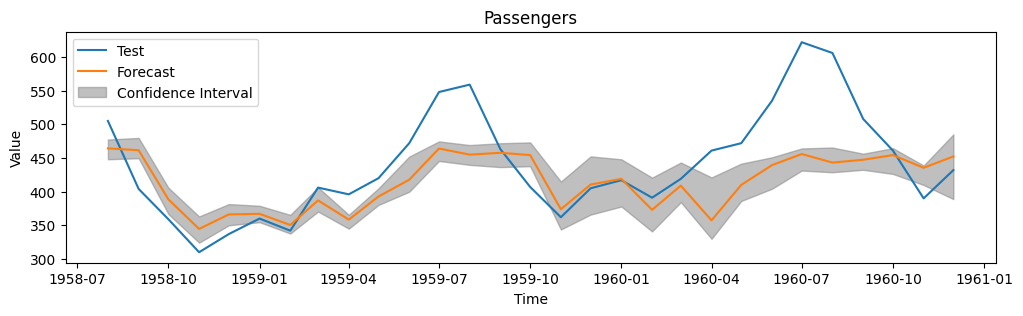

In [99]:
plt.figure(figsize=(12,3))
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.plot(test[date_variable], forecast["target"], label = "Forecast")
plt.fill_between(test[date_variable], results["lower_bound"], results["upper_bound"], color = "gray", label = "Confidence Interval", alpha = 0.5)
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

### Performance Metrics

### wMAPE

In [100]:
results.drop(columns= ["mean", "std", "lower_bound", "upper_bound"], inplace = True)

quantiles_results = pd.DataFrame() 
quantiles_results["forecast"] = forecast["target"]
quantiles_results["bids"] = test[ts_variable].values
quantile = np.linspace(0.05, 0.95, 19)

for q in quantile:

    quantiles_results[f"q_{str(round(q,2)).replace('0.', '').ljust(2, '0')}"] = results.quantile(q, axis = 1)

quantiles_results

,forecast,bids,q_05,q_10,q_15,q_20,q_25,q_30,q_35,q_40,...,q_50,q_55,q_60,q_65,q_70,q_75,q_80,q_85,q_90,q_95
0,464.29,505.00,450.90,453.77,455.64,457.23,458.50,459.52,460.21,460.25,...,463.09,465.61,467.40,469.09,469.65,469.65,469.68,469.75,470.02,470.98
0,461.53,404.00,452.17,454.27,455.32,456.08,458.58,462.49,465.48,466.62,...,467.85,468.04,468.32,468.61,469.41,470.47,471.40,472.16,472.78,472.89
0,388.51,359.00,373.47,374.45,376.30,378.41,379.56,379.94,380.31,380.67,...,383.67,386.08,388.91,391.79,393.62,394.93,395.66,395.66,396.56,400.64
0,344.59,310.00,331.97,335.36,336.15,336.19,337.31,339.30,340.68,340.84,...,341.29,341.56,342.29,343.07,344.37,345.93,349.58,355.83,360.80,361.26
0,366.18,337.00,354.67,357.16,359.34,361.43,362.68,363.25,363.63,363.63,...,364.90,366.05,366.34,366.52,367.42,368.66,370.03,371.54,373.79,378.64
0,367.06,360.00,357.82,361.48,362.34,362.39,362.88,363.72,364.31,364.41,...,366.01,367.36,369.20,371.10,371.74,371.76,372.05,372.68,373.47,374.81
0,350.48,342.00,343.35,344.71,345.20,345.44,346.46,348.11,349.36,349.82,...,350.27,350.32,350.46,350.61,352.44,355.11,357.27,358.81,360.66,363.62
0,387.00,406.00,375.21,379.66,380.96,381.36,382.36,383.85,384.84,384.85,...,388.34,391.48,392.96,394.24,394.77,394.94,395.11,395.28,396.30,400.31
0,358.42,396.00,348.00,349.00,350.06,351.15,352.03,352.75,353.41,353.94,...,354.43,354.45,355.26,356.17,358.06,360.42,361.75,361.76,361.94,362.71
0,392.76,420.00,385.15,386.01,386.69,387.31,387.69,387.87,388.00,388.00,...,391.01,393.73,394.51,395.06,396.42,398.19,399.32,399.67,400.27,401.75


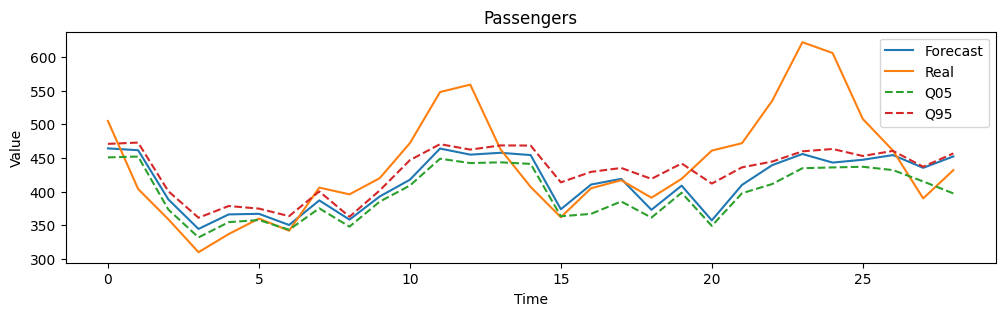

In [106]:
plt.figure(figsize=(12,3))
index = list(range(len(quantiles_results["forecast"])))
plt.plot(index, quantiles_results["forecast"], label = "Forecast")
plt.plot(index, quantiles_results["bids"], label = "Real")
plt.plot(index, quantiles_results["q_05"], label = "Q05", linestyle = "--")
plt.plot(index, quantiles_results["q_95"], label = "Q95", linestyle = "--")
plt.legend()
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show() 

In [ ]:
def calculate_mae(df, variable):

    abs_diff = (df[variable] - df["bids"]).abs()
    mae = abs_diff.mean()

    return float(mae)

def calculate_mape(df, variable):

    abs_diff = (df[variable] - df["bids"]).abs()
    mape = (abs_diff / df["bids"].abs()).mean() * 100

    return float(mape)


def calculate_wmape(df, variable):

    abs_diff = (df[variable] - df["bids"]).abs()
    mae = abs_diff.mean()

    wmape = mae / df["bids"].mean()

    return float(wmape)

print(f"{calculate_mae(quantiles_results, variable = 'forecast') = }")
print(f"{calculate_mape(quantiles_results, variable = 'forecast') = }")
print(f"{calculate_wmape(quantiles_results, variable = 'forecast') = }\n")

print(f"{calculate_mae(quantiles_results, variable = 'q_05') = }")
print(f"{calculate_mape(quantiles_results, variable = 'q_05') = }")
print(f"{calculate_wmape(quantiles_results, variable = 'q_05') = }")

calculate_mae(quantiles_results, variable = 'forecast') = 46.772037215919326
calculate_mape(quantiles_results, variable = 'forecast') = 9.743032654556
calculate_wmape(quantiles_results, variable = 'forecast') = 0.10622516087882061

calculate_mae(quantiles_results, variable = 'q_05') = 53.58501845881519
calculate_mape(quantiles_results, variable = 'q_05') = 10.991309773830809
calculate_wmape(quantiles_results, variable = 'q_05') = 0.12169829550517977


### PAC (Probabilistic ACcuracy)

In [140]:
# Example 
def quantile_comparison(df, perc_cols, percentiles):

    df_copy = df.copy() 

    for c in perc_cols:
        df_copy[f'quality_{c}'] = (df_copy['bids'] <= df_copy[c]).astype(int)

    for c, p in zip(perc_cols, percentiles):
        df_copy[f'diff_{c}'] = df_copy[f'quality_{c}'] - p

    return df_copy

quantile_str = [f"q_{str(round(q,2)).replace('0.', '').ljust(2, '0')}" for q in quantile]

# Example
quantile_comparison(quantiles_results, quantile_str[0:3], quantile[0:3])

,forecast,bids,q_05,q_10,q_15,q_20,q_25,q_30,q_35,q_40,...,q_80,q_85,q_90,q_95,quality_q_05,quality_q_10,quality_q_15,diff_q_05,diff_q_10,diff_q_15
0,464.29,505.00,450.90,453.77,455.64,457.23,458.50,459.52,460.21,460.25,...,469.68,469.75,470.02,470.98,0,0,0,-0.05,-0.10,-0.15
0,461.53,404.00,452.17,454.27,455.32,456.08,458.58,462.49,465.48,466.62,...,471.40,472.16,472.78,472.89,1,1,1,0.95,0.90,0.85
0,388.51,359.00,373.47,374.45,376.30,378.41,379.56,379.94,380.31,380.67,...,395.66,395.66,396.56,400.64,1,1,1,0.95,0.90,0.85
0,344.59,310.00,331.97,335.36,336.15,336.19,337.31,339.30,340.68,340.84,...,349.58,355.83,360.80,361.26,1,1,1,0.95,0.90,0.85
0,366.18,337.00,354.67,357.16,359.34,361.43,362.68,363.25,363.63,363.63,...,370.03,371.54,373.79,378.64,1,1,1,0.95,0.90,0.85
0,367.06,360.00,357.82,361.48,362.34,362.39,362.88,363.72,364.31,364.41,...,372.05,372.68,373.47,374.81,0,1,1,-0.05,0.90,0.85
0,350.48,342.00,343.35,344.71,345.20,345.44,346.46,348.11,349.36,349.82,...,357.27,358.81,360.66,363.62,1,1,1,0.95,0.90,0.85
0,387.00,406.00,375.21,379.66,380.96,381.36,382.36,383.85,384.84,384.85,...,395.11,395.28,396.30,400.31,0,0,0,-0.05,-0.10,-0.15
0,358.42,396.00,348.00,349.00,350.06,351.15,352.03,352.75,353.41,353.94,...,361.75,361.76,361.94,362.71,0,0,0,-0.05,-0.10,-0.15
0,392.76,420.00,385.15,386.01,386.69,387.31,387.69,387.87,388.00,388.00,...,399.32,399.67,400.27,401.75,0,0,0,-0.05,-0.10,-0.15


In [142]:
def quantile_comparison(df, perc_cols, percentiles):

    df_copy = df.copy() 

    for c in perc_cols:
        df_copy[f'quality_{c}'] = (df_copy['bids'] <= df_copy[c]).astype(int)

    for c, p in zip(perc_cols, percentiles):
        df_copy[f'diff_{c}'] = df_copy[f'quality_{c}'] - p

    check_cols = [f'diff_{c}' for c in perc_cols]
    df_quantile_comp = df_copy[check_cols].values.mean()

    return float(df_quantile_comp)

print(f"{quantile_comparison(quantiles_results, quantile_str, quantile) = }")

quantile_comparison(quantiles_results, quantile_str, quantile) = -0.10798548094373868


## SK - Forecast

In [203]:
def read_dataset():
    
       url = "https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv" 
       data = pd.read_csv(url, sep=',')

       data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
       data = data.set_index('Time')
       data = data.asfreq('30min')
       data = data.sort_index()
       data = data.drop(columns='Date')
       data = data.resample(rule='D', closed='left', label ='right').agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})
       
       # Normalize Holiday 
       data["Holiday"] = data["Holiday"].astype(int)
       
       return data 

data = read_dataset()
data

,Demand,Temperature,Holiday
Time,,,
2012-01-01,"82,531.75",21.05,1
2012-01-02,"227,778.26",26.58,1
2012-01-03,"275,490.99",31.75,1
2012-01-04,"258,955.33",24.57,0
2012-01-05,"213,792.38",18.19,0
...,...,...,...
2014-12-28,"173,292.33",18.19,0
2014-12-29,"196,116.23",24.54,0
2014-12-30,"188,570.26",17.68,0


In [204]:
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2014-07-31 23:59:00'
train = data.loc[:end_train, :].copy()
test   = data.loc[end_train:, :].copy()

print(f'{train.shape = }')
print(f'{test.shape = }')

train.shape = (943, 3)
test.shape = (152, 3)


In [205]:
ts_variable = "Demand"
exo_variables = ["Temperature", "Holiday"]

Text(0, 0.5, 'Demand')

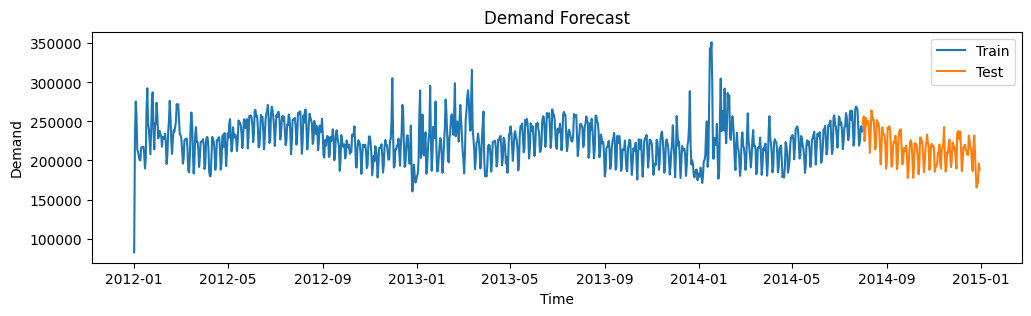

In [206]:
plt.figure(figsize = (12,3))
plt.plot(train.index, train[ts_variable], label = "Train")
plt.plot(test.index, test[ts_variable], label = "Test")
plt.legend()
plt.title("Demand Forecast")
plt.xlabel("Time")
plt.ylabel("Demand")

In [207]:
# Forecaster
forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(n_estimators = 50, random_state = 666),
                lags = 14 # Place holder that will be replaced during the search
            )

forecaster.fit(train[ts_variable], exog = train[exo_variables])
forecaster

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(n_estimators=50, random_state=666) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: None 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['Temperature', 'Holiday'] 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-07-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 666, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
fit_kwargs: 

Information of backtesting process
----------------------------------
An already trained forecaster is to be used. Window size: 14
Number of observations used for backtesting: 929
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 943
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 929 observations.

Fold: 0
    Training:   No training in this fold
    Validation: 2012-01-15 00:00:00 -- 2014-07-31 00:00:00  (n=929)



100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


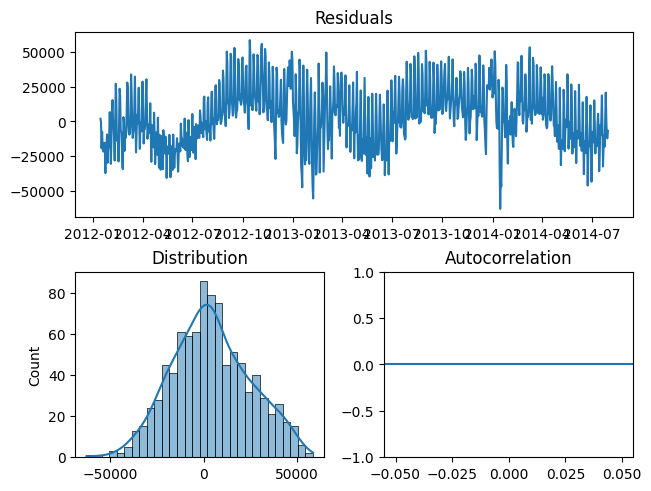

In [208]:
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = train[ts_variable],
                                    steps              = len(train),
                                    exog               = train[exo_variables],
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                               )

residuals = predictions_backtest['pred'] - train[ts_variable]
plot_residuals(residuals=residuals)
plt.savefig("img/residuals.png", dpi = 300, bbox_inches='tight')
plt.show()

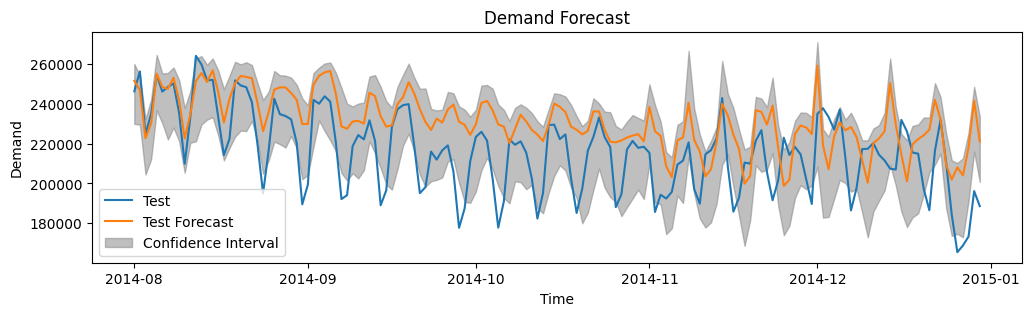

In [209]:
interval_pred = forecaster.predict_interval(steps = len(test), interval = [1, 90], exog = test[exo_variables], n_boot=250)


plt.figure(figsize=(12,3))
# plt.plot(train.index, train[ts_variable], label = f'Train')
plt.plot(test.index, test[ts_variable], label = f'Test')
plt.plot(test.index, interval_pred["pred"], label = f'Test Forecast')
plt.fill_between(test.index, interval_pred["lower_bound"], interval_pred["upper_bound"], color = "gray", label = "Confidence Interval", alpha = 0.5)
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Demand Forecast")
plt.legend()
plt.savefig("img/demand_ml_forecasting.png", dpi = 300, bbox_inches='tight')
plt.show() 

In [210]:
predictions = forecaster.predict_dist(steps=7, distribution=norm, n_boot=1000, exog = test[exo_variables])
predictions

,loc,scale
2014-08-01,"251,312.62","7,198.34"
2014-08-02,"245,965.28","7,074.37"
2014-08-03,"222,771.64","7,424.09"
2014-08-04,"231,576.51","8,152.24"
2014-08-05,"253,697.28","7,900.06"
2014-08-06,"246,729.78","7,945.24"
2014-08-07,"245,099.11","7,828.84"
